In [1]:
import os
import cv2
import math
import time
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt

In [2]:
class Timer():
    def __init__(self):
        pass
    
    def start(self):
        self.start_time = time.time()
        
    def end_print(self, print_row):
        end_time = time.time()
        time_passed = round(end_time - self.start_time, 4)
        
        print(f'{print_row} {time_passed} sec')
        
    def time_passed(self):
        end_time = time.time()
        time_passed = round(end_time - self.start_time, 8)
        
        return time_passed

In [3]:
class Quad_Element():
    def __init__(self, dofs_):
        self.nu = 0.3
        self.dofs = dofs_
        
        # Local stiffness matrix assembly
        A11 = np.transpose(np.array([
            [12, 3, -6, -3],
            [3, 12, 3, 0],
            [-6, 3, 12, -3],
            [-3, 0, -3, 12]
        ]))
        
        A12 = np.array([
            [-6, -3, 0, 3],
            [-3, -6, -3, -6],
            [0, -3, -6, 3],
            [3, -6, 3, -6]
        ])
        
        B11 = np.transpose(np.array([
            [-4, 3, -2, 9],
            [3, -4, -9, 4],
            [-2, -9, -4, -3],
            [9, 4, -3, -4]
        ]))
        
        B12 = np.array([
            [2, -3, 4, -9],
            [-3, 2, 9, -2],
            [4, 9, 2, 3],
            [-9, -2 , 3, 2]
        ])
        
        block_1 = np.concatenate((np.concatenate((A11, A12), axis = 1), 
                                  np.concatenate((np.transpose(A12), A11), axis = 1)), axis = 0)
        block_2 = np.concatenate((np.concatenate((B11, B12), axis = 1), 
                                  np.concatenate((np.transpose(B12), B11), axis = 1)), axis = 0)
        
        self.local_K = (block_1 +  self.nu*block_2)/ (1 - pow(self.nu, 2)) / 24

In [4]:
class FEM_2D():
    def __init__(self, config_nx, config_ny, config_R):
        
        self.nx = config_nx                          # Nodes along Ox
        self.ny = config_ny                          # Nodes along Oy
        self.ex = config_nx - 1                      # Elems along Ox
        self.ey = config_ny - 1                      # Elems along Oy
        self.n_elem = self.ex * self.ey
        self.elements = []
        
        self.n_dofs = 2 * self.nx * self.ny         # Number of degrees of freedom across all mesh
        self.all_dofs = np.arange(0, self.n_dofs)   # List containing DOFs indicies
        self.fixed_dofs = np.array([], np.int32)    # List containing indicies of fixed DOFs
        self.dofs_matr = np.zeros((self.n_elem, 8), np.int32)
        
        self.K = None                               # Global Stiffness Matrix
        self.F = np.zeros(self.n_dofs)              # Loads vector, size = number of DOFs
        self.U = np.zeros(self.n_dofs)              # Displacements, size = number of DOFs
        
        self.canv = np.ones((self.ny, self.nx))    # Empty canvas for marking boundary conds & loads
        
        self.filter_r = config_R
        
        self.nu = 0.3
        
        # Local stiffness matrix assembly
        A11 = np.transpose(np.array([
            [12, 3, -6, -3],
            [3, 12, 3, 0],
            [-6, 3, 12, -3],
            [-3, 0, -3, 12]
        ]))
        
        A12 = np.array([
            [-6, -3, 0, 3],
            [-3, -6, -3, -6],
            [0, -3, -6, 3],
            [3, -6, 3, -6]
        ])
        
        B11 = np.transpose(np.array([
            [-4, 3, -2, 9],
            [3, -4, -9, 4],
            [-2, -9, -4, -3],
            [9, 4, -3, -4]
        ]))
        
        B12 = np.array([
            [2, -3, 4, -9],
            [-3, 2, 9, -2],
            [4, 9, 2, 3],
            [-9, -2 , 3, 2]
        ])
        
        block_1 = np.concatenate((np.concatenate((A11, A12), axis = 1), 
                                  np.concatenate((np.transpose(A12), A11), axis = 1)), axis = 0)
        block_2 = np.concatenate((np.concatenate((B11, B12), axis = 1), 
                                  np.concatenate((np.transpose(B12), B11), axis = 1)), axis = 0)
        
        self.element_K = (block_1 +  self.nu*block_2)/ (1 - pow(self.nu, 2)) / 24
        
    def form_elements(self):
        
        for i in range(self.ex * self.ey):
            lb_i = self.ny * (i // self.ey) + (i % self.ey) + 1 # index of left bottom node
            
            elem_dofs = np.array([
                2*lb_i, 2*lb_i + 1,
                2*(lb_i + self.ny), 2*(lb_i + self.ny) + 1,
                2*(lb_i + self.ny - 1), 2*(lb_i + self.ny - 1) + 1,
                2*(lb_i - 1), 2*(lb_i - 1) + 1
            ])
            
            new_element = Quad_Element(elem_dofs)
            self.elements.append(new_element)
            self.dofs_matr[i] = elem_dofs
            
    def assemble_sparse_K(self, dens, penal, E_void, E0):
        
        global_iK = np.zeros(64 * self.n_elem)
        global_jK = np.zeros(64 * self.n_elem)
        global_vK = np.zeros(64 * self.n_elem)
        
        for ei in range(self.dofs_matr.shape[0]):
            elem_density = dens[ei]
            
            young_modulus = E_void + pow(elem_density, penal) * (E0 - E_void)
            KE = self.element_K * young_modulus
            
            iK = np.kron(self.dofs_matr[ei], np.ones(8))
            jK = np.reshape(np.kron(self.dofs_matr[ei], np.reshape(np.ones(8), (8,1))), -1)
            val_K = np.reshape(KE, -1)
            
            global_iK[ei*64 : (ei+1)*64] = iK
            global_jK[ei*64 : (ei+1)*64] = jK
            global_vK[ei*64 : (ei+1)*64] = val_K
            
        self.sparse_K = sparse.coo_matrix((global_vK, (global_iK, global_jK)), shape = (self.n_dofs, self.n_dofs)).tocsr()
        
    def solve_U(self):
        free_dofs = np.setdiff1d(self.all_dofs, self.fixed_dofs)
        self.U[free_dofs] = spsolve(self.sparse_K[free_dofs, :][:, free_dofs], self.F[free_dofs])
        
        return self.U
            
    # Fix node (=dofs) in [row, col] position 
    def fix_node(self, row, col, fix_x, fix_y):
        node_ind = self.ny * col + row
        
        dof_x = node_ind * 2
        dof_y = node_ind * 2 + 1
        
        if (fix_x == True):
            self.fixed_dofs = np.append(self.fixed_dofs, dof_x)
            
        if (fix_y == True):
            self.fixed_dofs = np.append(self.fixed_dofs, dof_y)
            
        self.mark_node(row, col, -3.0)
    
    # Fix nodes (=dofs) in whole row
    def fix_row(self, row, fix_x, fix_y):
        for col in range(self.nx):
            self.fix_node(row, col, fix_x, fix_y)
    
    # Fix nodes (=dofs) in whole column
    def fix_col(self, col, fix_x, fix_y):
        for row in range(self.ny):
            self.fix_node(row, col, fix_x, fix_y)
    
    # Adds (Fx, Fy) load to [row, col] node 
    def apply_load(self, row, col, Fx, Fy):
        node_ind = self.ny * col + row
        
        dof_x = node_ind * 2
        dof_y = node_ind * 2 + 1
        
        self.F[dof_x] = Fx
        self.F[dof_y] = Fy
        
        self.mark_node(row, col, 3.0)
        
    def draw_marked(self):
        plt.imshow(self.canv, cmap = 'gist_earth')
        
    def mark_node(self, row, col, val):
        for i_row in range(row - 2, row + 3):
            for i_col in range(col - 2, col + 3):
                if (i_row >= 0 and i_col >= 0 and i_row < self.ny and i_col < self.nx):
                    self.canv[i_row, i_col] = val
        self.canv[row, col] = 0
        
    def H_ei(self, e1, e2):
        e1_col = e1 // (self.ey)
        e1_row = e1 % (self.ey)
        e2_col = e2 // (self.ey)
        e2_row = e2 % (self.ey)
        
        return max(0, self.filter_r - np.sqrt((e1_col - e2_col)**2 + (e1_row - e2_row)**2))
    
    def prepare_filter(self):
        H_lines = []
        
        for i in range(self.n_elem):
            neighbors = np.zeros(self.n_elem)
            
            #for j in range(self.n_elem):
            #    neighbors[j] = self.H_ei(i, j)
                
            e_row = i % self.ey
            e_col = i // self.ey
            
            min_row = max(0, e_row - math.ceil(self.filter_r))
            max_row = min(self.ey, e_row + math.ceil(self.filter_r))
            min_col = max(0, e_col - math.ceil(self.filter_r))
            max_col = min(self.ex, e_col + math.ceil(self.filter_r))
            
            for i_row in range(min_row, max_row):
                for i_col in range(min_col, max_col):
                    neighbors[i_col*self.ey + i_row] = max(0, self.filter_r - 
                                                           np.sqrt((e_col - i_col)**2 + (e_row - i_row)**2))
            
                
            H_lines.append(neighbors)
            
        H = np.stack(H_lines, axis = 0)
        sH = np.sum(H, axis = 1)
        
        return H, sH
    
    def save_txt(self, filename, densities):
        outfile = open(filename, 'w')
        
        outfile.write(f'{self.nx} {self.ny}\n')
        outfile.write('-section-\n')
        
        for di in range(self.U.shape[0]):
            outfile.write(f'{self.U[di]}\n')
        outfile.write('-section-\n')
        
        for fd in range(self.fixed_dofs.shape[0]):
            outfile.write(f'{self.fixed_dofs[fd]}\n')
            
        outfile.write('-section-\n')
        for d_i in range(densities.shape[0]):
            outfile.write(f'{densities[d_i]}\n')
            
            
        outfile.close()

In [5]:
class Config():
    def __init__(self):
        self.vol_frac = 0.0
        self.penalize = 0
        self.move = 0 
        self.dense_delta = 0.0
        self.max_iter = 0
        self.E_void = 0
        self.E0 = 0
        self.H = None
        self.sH = None
        self.fem_save_iters = None

In [6]:
def optimize(FEM_solver, config, verbose, video_flag):
    timer = Timer()
    iteration = 0
    
    ex = FEM_solver.nx - 1
    ey = FEM_solver.ny - 1
    
    x = np.array([config.vol_frac for i in range(ex*ey)])
    xPhys = x
    
    dense_c_norm = 1
    gamma = 1e-3

    while (dense_c_norm > config.dense_delta):
        iteration += 1
        if (iteration%10 == 0 and verbose == True):
            print(f'Iteration {iteration}, c-norm = {dense_c_norm}')
        
        timer.start()
        # Matrix assembly with individual densities
        FEM_solver.assemble_sparse_K(xPhys, config.penalize, config.E_void, config.E0)
        
        # Displacements
        timer.start()
        u = FEM_solver.solve_U()
        
        # Compliance, Sensitivity, Filtering
        c = 0
        dc = np.array([])
        dv = np.array([])
        
        timer.start()
        for elem_index, elem in enumerate(FEM_solver.elements):
            # Individual compliance
            ce = np.dot(np.dot(u[elem.dofs], FEM_solver.element_K), u[elem.dofs])
            young_modulus = config.E_void + pow(xPhys[elem_index], config.penalize) * (config.E0 - config.E_void)

            c += young_modulus * ce
            curr_dc = -config.penalize * (config.E0 - config.E_void) * pow(xPhys[elem_index], config.penalize - 1) * ce

            dc = np.append(dc, curr_dc)
            dv = np.append(dv, 1)

        # Filtering
        timer.start()
        for i in range(dc.shape[0]):
            sum_1 = 0
            sum_1 = np.dot(dc * x, config.H[i])
            dc[i] = sum_1 / ((max(gamma, x[i]) * config.sH[i]))

        # Optimality criteria
        lambda_1 = 0
        lambda_2 = 1e9

        x_new = np.zeros(x.shape)
        while ((lambda_2 - lambda_1) / (lambda_2 + lambda_1)) > 1e-3: #Binary search of lambda
            lambda_mid = (lambda_1 + lambda_2) / 2

            for i in range(x.shape[0]):
                B_e = np.sqrt(-dc[i] / (lambda_mid))
                if (x[i] * B_e <= max(0, x[i] - config.move)):
                    x_new[i] = max(0, x[i] - config.move)
                elif (x[i] * B_e >= min(1, x[i] + config.move)):
                    x_new[i] = min(1, x[i] + config.move)
                else:
                    x_new[i] = x[i] * B_e

            xPhys = x_new

            if (np.sum(xPhys) > config.vol_frac * ey * ex):
                lambda_1 = lambda_mid
            else:
                lambda_2 = lambda_mid
        
        if (iteration in config.fem_save_iters and verbose == True):
            FEM_solver.save_txt(f'Iter_{iteration}.txt', xPhys)
        if (iteration == config.max_iter):
            break
        dense_c_norm = np.max(np.abs(x_new - x))
        x = x_new
        
        # Filming optimization process
        if (video_flag == True):
                
            x_matrix = np.zeros((ey, ex))
            for col in range(ex):
                for row in range(ey):
                    x_matrix[row][col] = xPhys[col*ey + row]
            
            plt.title(str(iteration))
            plt.imshow(x_matrix, cmap = 'seismic', interpolation = 'gaussian', interpolation_stage = 'rgba')
            plt.savefig(f'VideoFrames\\iter_{iteration}.jpg')
            
    if (video_flag == True):
        image_folder = "VideoFrames\\"
        video_name = 'ConceptEvolution.mp4'
        
        def sort_key(img_name):
            img_num = int((img_name.split('_'))[-1].split('.')[0])
            return img_num

        images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
        images = sorted(images, key = sort_key)
        
        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, 0, 9, (width,height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()
        
    return xPhys

In [7]:
from math import sin, cos
def circle_load(x_center, y_center, Rad, FEM_solver):
    alpha = 0
    for i in range(158):
        x_load = x_center + cos(alpha)*Rad
        y_load = y_center - sin(alpha)*Rad
        
        FEM_solver.apply_load(int(y_load), int(x_load), 0, -1)
        FEM_solver.apply_load(int(y_load), 30-int(x_load), 0, -1)
        
        alpha += 0.01

Task scheme:


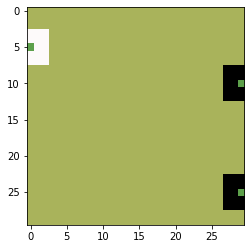

In [22]:
config = Config()

nx = 30
ny = 30

config.nx = nx
config.ny = ny

config.vol_frac = 0.3
config.penalize = 3

config.dense_delta = 0.01
config.max_iter = 2

config.E0 = 1
config.E_void = 1e-9

config.filter_r = 1.5
config.move = 0.2

config.fem_save_iters = [1, 15, 35, 50]

FEM_solver = FEM_2D(config.nx, config.ny, config.filter_r)

FEM_solver.fix_node(10, 29, 1, 1)
FEM_solver.fix_node(25, 29, 1, 1)
FEM_solver.apply_load(5, 0, 0, -1)

print('Task scheme:')
FEM_solver.draw_marked()

In [23]:
timer = Timer()

timer.start()
FEM_solver.form_elements()
timer.end_print('Form elements taken: ')

timer.start()
config.H, config.sH = FEM_solver.prepare_filter()
timer.end_print('Filter preparation taken: ')

print('Optimization start')

timer.start()
xPhys_opt = optimize(FEM_solver, config, True, False)
timer.end_print('Optimization taken: ')

ey = ny - 1
ex = nx - 1

x_matrix = np.zeros((ey, ex))
for col in range(ex):
    for row in range(ey):
        x_matrix[row][col] = xPhys_opt[col*ey + row]

Form elements taken:  0.036 sec
Filter preparation taken:  0.03 sec
Optimization start
Optimization taken:  0.2977 sec


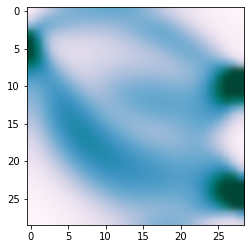

In [24]:
plt.imshow(x_matrix, cmap = 'PuBuGn', interpolation = 'gaussian', interpolation_stage = 'rgba')
plt.savefig('Result.jpg')